In [ ]:
!git clone https://github.com/Nazar1997/Sparse_vector.git sparse_vector

In [1]:
import os
import numpy as np
import pandas as pd
import gc

from joblib import load
from tqdm.notebook import tqdm
from torch.utils import data

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

from sparse_vector.sparse_vector import SparseVector
from interpretation_framework.data_preparation import chrom_reader, get_train_test_dataset
from interpretation_framework.train_test import set_random_seed, train
from interpretation_framework.cnn_model import DeepCNN_12_layers
from interpretation_framework.interpretation import cnn_interpretation_pipeline, get_ranked_features

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Preparation

In [12]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
feature_names = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells') 
                 if i.endswith('.pkl')]

In [3]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}
ZDNA = load('../data_hg_38/targets/sparse/zdna.pkl')

DNA_features = {feature: load(f'../data_hg_38/features/sparse_max_scaled/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

CPU times: user 4.79 s, sys: 4.9 s, total: 9.69 s
Wall time: 33.8 s


In [4]:
np.random.seed(10)

width = 100
train_dataset, test_dataset = get_train_test_dataset(width, chroms, feature_names, DNA, DNA_features, ZDNA, 5382)

100%|██████████| 572274/572274 [00:07<00:00, 80912.67it/s]


In [5]:
params = {'batch_size':1,
          'num_workers':16,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# Init Model

In [ ]:
set_random_seed(42)
torch.cuda.empty_cache()

with torch.cuda.device(device):
    model_path = '../models/zdna/max_scaled_omicses.pt'
    state_dict = torch.load(model_path, weights_only=True)
    model = DeepCNN_12_layers(width, len(feature_names))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict)
    model = model.module
    model = model.to(device)

# Interpretation

In [13]:
model.eval()

DeepCNN_12_layers(
  (seq): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): GroupNorm(2, 4, eps=1e-05, affine=True)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): GroupNorm(4, 8, eps=1e-05, affine=True)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): GroupNorm(8, 16, eps=1e-05, affine=True)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): GroupNorm(16, 32, eps=1e-05, affine=True)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): GroupNorm(16, 64, eps=1e-05, affine=True)
    (15): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (16): ReLU()
    (17): GroupNorm(32, 128, eps=1e-05, affine=True)
    (18): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU()
    (20): Grou

In [32]:
mean_GB = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                      width, len(feature_names), 
                                      './interpretation_results/zdna/mean_GuidedBackprop', 
                                      'GuidedBackprop')

done interpretation
Averaged tensor shape: torch.Size([326])
Averaged tensor: tensor([-0.5095,  0.4182,  0.4760, -0.3778, -0.1580, -0.1178, -0.0373, -0.0188,
        -0.0938, -0.0072, -0.0409, -0.0367, -0.0508, -0.0102, -0.0133, -0.0307,
        -0.0389, -0.0572, -0.0762, -0.0823, -0.0845, -0.0902, -0.0880, -0.0865,
        -0.0865, -0.0811, -0.0767, -0.0860, -0.0985, -0.0691, -0.0745, -0.0327,
        -0.0337, -0.0266, -0.0153, -0.0552, -0.0641, -0.0273,  0.0630,  0.0468,
        -0.0374, -0.0153, -0.0404, -0.0418, -0.0523, -0.0353, -0.0379, -0.0450,
        -0.0487, -0.0531, -0.0506, -0.0578, -0.0694, -0.0742, -0.0785, -0.0805,
        -0.0822, -0.0855, -0.0820, -0.0811, -0.0827, -0.0815, -0.0844, -0.0839,
        -0.0825, -0.0823, -0.0829, -0.0846, -0.0839, -0.0844, -0.0818, -0.0879,
        -0.0889, -0.0877, -0.0837, -0.0704, -0.0764, -0.0755, -0.0541, -0.0561,
        -0.0439, -0.0391, -0.0841, -0.0340, -0.0497, -0.0571, -0.0425, -0.0513,
        -0.0708, -0.0404, -0.0279, -0.0506

In [33]:
mean_IG = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                      width, len(feature_names), 
                                      './interpretation_results/zdna/mean_IntegratedGradients', 
                                      'IntegratedGradients')

done interpretation
Averaged tensor shape: torch.Size([326])
Averaged tensor: tensor([-8.9328e+00,  4.7678e+01,  3.2869e+01, -2.2144e+01,  0.0000e+00,
        -7.0260e-05,  4.1751e-04, -6.9284e-03, -5.4313e-04, -5.9093e-04,
        -3.3092e-03,  0.0000e+00,  0.0000e+00, -3.1100e-06,  9.8885e-04,
         1.2378e-05,  0.0000e+00,  0.0000e+00, -2.2350e-03,  5.9600e-06,
         7.2796e-05,  8.2295e-06,  0.0000e+00,  0.0000e+00, -8.1368e-05,
        -5.0103e-06,  0.0000e+00,  2.1357e-05, -5.3455e-05,  1.3502e-04,
        -4.4799e-04,  0.0000e+00,  0.0000e+00,  3.5537e-05,  3.9024e-06,
         4.2802e-06,  5.6129e-04,  4.2020e-04,  5.8004e-02,  7.6361e-06,
         6.1551e-04,  3.0056e-03, -5.5114e-03, -8.0370e-03, -2.7346e-05,
        -9.0290e-05,  2.8064e-05,  5.1989e-05,  0.0000e+00,  9.2441e-06,
         3.4335e-04,  8.9085e-03, -2.3445e-07,  1.5027e-04,  4.9149e-06,
        -6.7220e-06, -8.1479e-05,  0.0000e+00,  0.0000e+00, -3.0623e-04,
         0.0000e+00,  4.9453e-04,  0.0000e+00,

In [36]:
mean_IG_prefiltered = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                                  width, len(feature_names), 
                                                  './interpretation_results/zdna/mean_IntegratedGradients_prefiltered', 
                                                  'IntegratedGradients', "prefiltering")

done interpretation
Averaged tensor shape: torch.Size([326])
Averaged tensor: tensor([-4.4354e-01,  8.3761e-01,  5.9660e-01, -6.5377e-01,  0.0000e+00,
        -1.2747e-06,  6.2606e-05,  2.5103e-03, -1.6051e-05, -6.0362e-05,
        -5.8383e-04,  0.0000e+00,  0.0000e+00, -7.8492e-05, -5.5964e-04,
         7.9990e-07,  1.3000e-07,  0.0000e+00,  5.1175e-06,  5.0337e-06,
         1.1613e-05,  1.6492e-07,  0.0000e+00,  0.0000e+00,  1.8045e-05,
        -1.1357e-06,  0.0000e+00, -1.5903e-07, -2.7494e-06,  1.2830e-05,
         5.5951e-06,  0.0000e+00,  1.2880e-07,  1.1002e-08, -2.5586e-09,
         2.7172e-08,  1.4315e-05,  6.6973e-05,  3.2183e-02, -7.6258e-08,
         1.3365e-04,  6.5736e-04,  1.7746e-03,  5.3509e-04,  9.6448e-06,
        -7.5878e-07,  3.3278e-06,  7.0323e-06,  0.0000e+00, -5.2782e-08,
         1.0233e-03,  7.9052e-04, -1.6454e-07,  3.6001e-05, -2.0039e-06,
        -1.2613e-06,  9.0249e-05,  0.0000e+00,  0.0000e+00,  3.2654e-05,
        -7.4038e-07,  5.7585e-05,  0.0000e+00,

In [34]:
mean_DEC = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                       width, len(feature_names), 
                                       './interpretation_results/zdna/mean_Deconvolution', 
                                       'Deconvolution')

done interpretation
Averaged tensor shape: torch.Size([326])
Averaged tensor: tensor([-56.0425, 153.9568, 166.3274, 154.3899, 159.7747, 172.0435, 165.9574,
        164.0316, 153.7026, 136.3351, 112.8520,  77.9658,  56.5868,  51.0120,
         46.1098,  38.1776,  29.2050,  21.8121,   9.2719,  -8.3841, -27.9390,
        -48.1616, -60.0857, -64.0579, -64.7614, -64.9394, -66.1454, -63.0680,
        -50.9786, -48.2036, -52.3935, -61.5297, -57.2165, -33.7965, -32.5800,
        -25.2550, -15.9044,  -5.4515,  14.9157,  19.5152,  10.0230,   6.7653,
        -17.3802, -14.0931,  -7.1791,  -5.6982,  -9.1796, -15.1058, -21.8453,
        -22.5053, -22.7587, -25.1003, -29.7184, -37.2282, -47.3075, -53.3697,
        -57.4226, -59.5009, -62.4635, -62.5079, -63.5649, -64.2247, -64.8241,
        -65.2751, -64.7787, -63.7186, -62.6944, -64.1961, -65.7063, -62.7096,
        -62.7276, -59.2691, -60.7855, -61.8937, -57.6205, -56.1694, -53.4845,
        -53.4128, -51.2048, -46.8936, -50.9585, -39.0597, -43.25

In [35]:
mean_IXG = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                       width, len(feature_names), 
                                       './interpretation_results/zdna/mean_InputXGradient', 
                                       'InputXGradient')

done interpretation
Averaged tensor shape: torch.Size([326])
Averaged tensor: tensor([-3.5201e+00,  6.2262e+00,  6.2891e+00, -6.1027e+00,  0.0000e+00,
         4.0629e-06,  2.4528e-04,  4.3127e-03, -8.3679e-05, -4.3069e-05,
        -8.2467e-04,  0.0000e+00,  0.0000e+00, -5.9391e-05,  2.8678e-04,
        -1.4346e-06,  0.0000e+00,  0.0000e+00,  2.0690e-04,  1.2930e-05,
        -2.1695e-05, -3.5356e-06,  0.0000e+00,  0.0000e+00,  3.1247e-05,
        -7.6975e-06,  0.0000e+00, -4.2361e-06,  4.5651e-05,  1.4253e-05,
         1.8219e-04,  0.0000e+00,  0.0000e+00,  2.0286e-05, -3.2321e-07,
         5.6056e-06,  1.0161e-04,  1.3267e-04,  7.4496e-02, -2.9015e-05,
         1.9010e-04,  1.7069e-03, -1.3852e-02, -2.4783e-04,  1.7896e-05,
        -3.2749e-07,  2.4449e-05,  4.0725e-05,  0.0000e+00,  4.4628e-06,
         2.9311e-03,  2.4717e-04, -1.6455e-07,  2.3967e-05,  1.2221e-05,
         1.0543e-06, -2.6762e-04,  0.0000e+00,  0.0000e+00, -9.1353e-05,
         0.0000e+00,  3.0196e-06,  0.0000e+00,

In [37]:
mean_IXG_prefiltered = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                                   width, len(feature_names), 
                                                  './interpretation_results/zdna/mean_InputXGradient_prefiltered', 
                                                   'InputXGradient', "prefiltering")

done interpretation
Averaged tensor shape: torch.Size([326])
Averaged tensor: tensor([-1.2402e-01,  1.4520e-01,  1.6044e-01, -2.4085e-01,  0.0000e+00,
        -5.5176e-06,  1.2223e-05,  1.9860e-04,  1.0363e-06, -1.3304e-05,
        -2.2182e-04,  0.0000e+00,  0.0000e+00, -4.7570e-05, -8.3274e-05,
         8.9554e-07, -2.6186e-07,  0.0000e+00,  1.8808e-05, -4.3595e-07,
        -1.2943e-05, -2.4217e-07,  0.0000e+00,  0.0000e+00, -3.1013e-06,
        -6.0711e-07,  0.0000e+00, -3.9397e-07,  6.2546e-06, -3.5737e-07,
        -6.3212e-05,  0.0000e+00,  2.6158e-07,  2.7298e-06,  1.7535e-07,
         2.4193e-07, -2.7677e-06,  6.6366e-06,  9.1194e-03,  5.2104e-07,
         3.2960e-05,  2.2935e-04,  4.9113e-04,  3.4446e-04,  1.1573e-06,
         2.2649e-06,  1.5076e-07,  3.1758e-06,  0.0000e+00,  3.6032e-07,
         2.8645e-04,  1.7119e-04,  2.6137e-08,  6.0505e-06,  1.3096e-08,
         2.2476e-08, -4.0083e-06,  0.0000e+00,  0.0000e+00,  1.4954e-06,
         1.2104e-07,  1.4789e-05,  0.0000e+00,

# Ranking

In [3]:
features_weights = {'IG' : mean_IG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
1,31149.965753
2,21443.424314
3,14613.847506
0,5954.825115
120,116.073815
103,106.888937
43,105.267715
7,104.541076
42,103.612341
10,102.168965


In [4]:
features_weights = {'IXG' : mean_IXG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
2,68246.159498
1,67562.964077
3,66421.235787
0,38354.883204
38,709.582898
42,250.534415
89,135.446345
103,116.564058
270,110.668742
10,108.962093


In [5]:
features_weights = {'GB' : mean_GB}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
2,776.759106
1,694.671632
0,624.483093
3,437.248283
323,266.903349
38,189.638051
39,166.520421
4,124.649782
324,105.294846
319,104.375871


In [6]:
features_weights = {'DEC' : mean_DEC}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
5,525.759134
2,511.613308
6,510.697708
7,505.931815
4,495.397271
3,482.071265
1,480.999645
8,480.370487
9,437.390947
10,379.276838


### Deconvolution gives unexpected results, so we exclude it from future ranking

In [8]:
features_weights = {'IG_prefiltered' : mean_IG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
1,64589.910156
3,50591.750000
2,45976.054688
0,34355.156250
38,2385.510742
169,607.736633
89,456.553986
83,442.072540
10,145.089920
14,143.222229


In [9]:
features_weights = {'mean_IXG_prefiltered' : mean_IXG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
3,199175.578125
2,132843.984375
1,120233.742188
0,102507.601562
38,7645.133301
169,3283.270264
89,1435.939697
120,1302.685303
250,1287.492676
134,897.116760


# Train on reduced omics features

In [ ]:
def train_on_reduced_omics(omics_features_num, filter_type="prefiltered"):
    feature_names_cut = features[:omics_features_num]
    width = 50
    train_dataset, test_dataset = get_train_test_dataset(width, chroms, feature_names_cut, DNA, DNA_features, ZDNA, 5382)
    
    set_random_seed(42)
    params = {'batch_size': 32,
              'num_workers':8,
              'shuffle':True}
    
    loader_train = data.DataLoader(train_dataset, **params)
    loader_test = data.DataLoader(test_dataset, **params)
    
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.cuda.device(device):
        model = DeepCNN_12_layers(width, omics_features_num)
        model = nn.DataParallel(model)
        model = model.to(device)
    opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)
    gc.collect()
    
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(
        model, opt, 20, loader_train, loader_test)
    
    print("Omics features num: {}".format(omics_features_num)) 
    
    print("Epoch {}".format(np.argmax(val_f1_log) + 1))
    print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
    print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
    print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
    print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

    print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))
    
    torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
               "./models/zdna/best_{}_omics_{}.pt".format(omics_features_num, filter_type))

## Prefiltering

In [13]:
features_weights = {'IG_prefiltered' : mean_IG_prefiltered, 
                    'IXG_prefiltered' : mean_IXG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)

In [14]:
features = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells')
            if i.endswith('.pkl')]

features_top = features_range.iloc[4:len(features)+4].index.tolist()

top = []
for index in features_top:
    top.append(features[index-4])

features = top

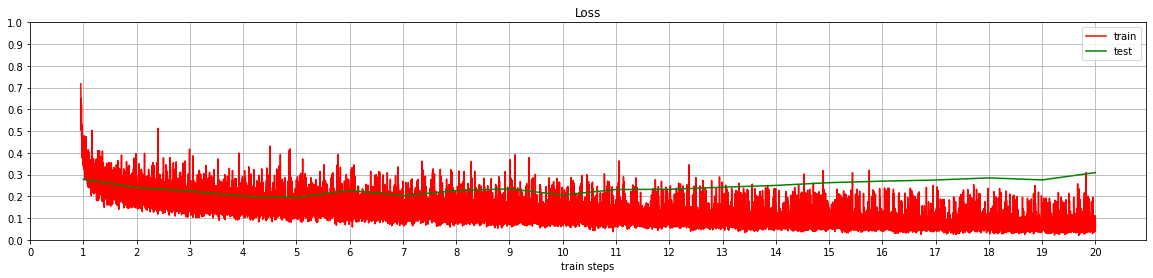

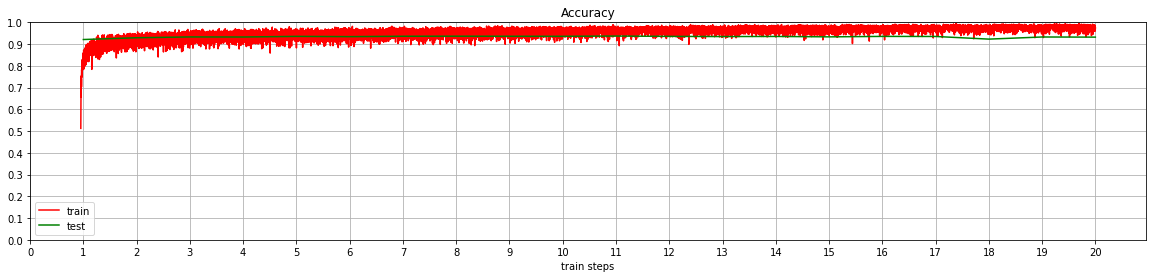

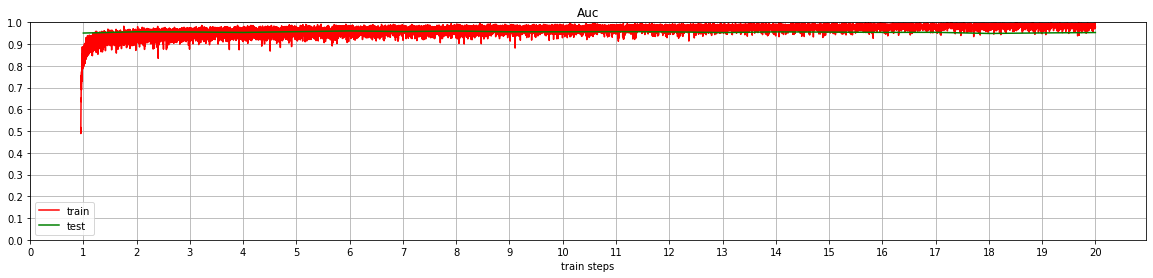

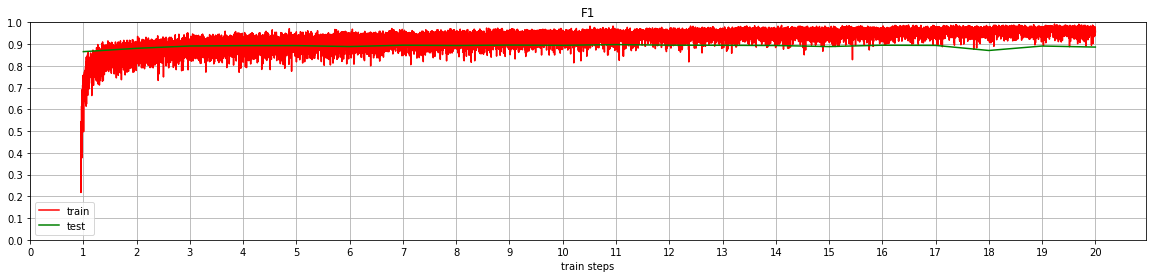

Time:  29113159.855440058
Epoch 20: ROC-AUC = 95.32%
Epoch 20: Precision = 0.914
Epoch 20: Recall = 0.862
Epoch 20: F1-score = 0.886
Final ROC-AUC = 95.32%
Final Precision = 0.914
Final Recall = 0.862
Final F1-score = 0.886
Omics features num: 10
Epoch 11
Max F1-score: 89.7739%
ROC-AUC: 95.7519%
Precision: 0.8966
Recall: 0.8997
Mean time for 1 epoch 3.22 minutes


In [24]:
train_on_reduced_omics(10)

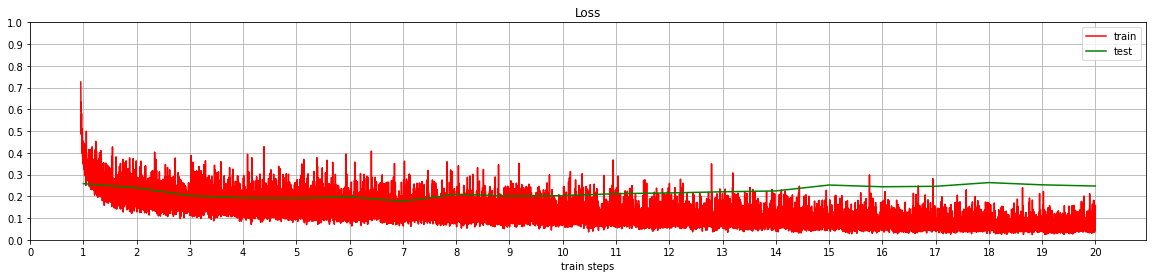

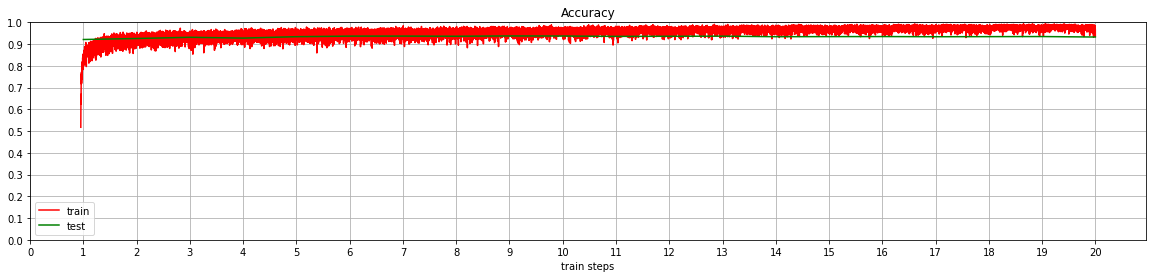

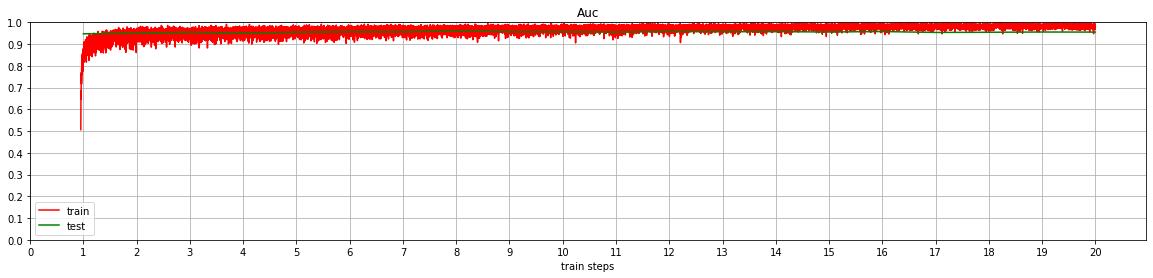

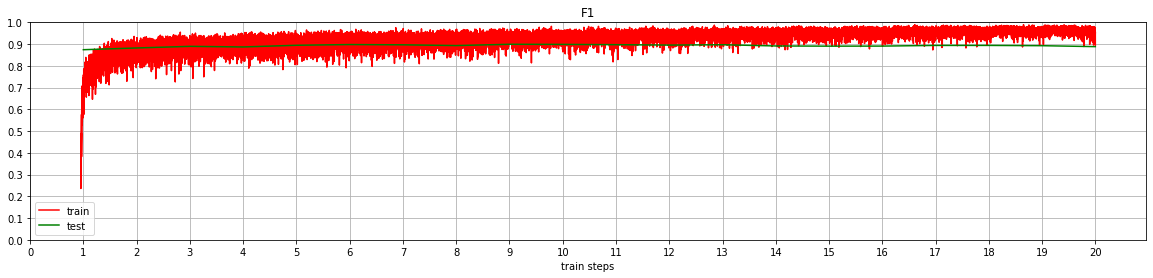

Time:  29113244.669004176
Epoch 20: ROC-AUC = 95.52%
Epoch 20: Precision = 0.905
Epoch 20: Recall = 0.873
Epoch 20: F1-score = 0.888
Final ROC-AUC = 95.52%
Final Precision = 0.905
Final Recall = 0.873
Final F1-score = 0.888
Omics features num: 20
Epoch 9
Max F1-score: 89.9170%
ROC-AUC: 95.6797%
Precision: 0.8934
Recall: 0.9058
Mean time for 1 epoch 3.45 minutes


In [25]:
train_on_reduced_omics(20)

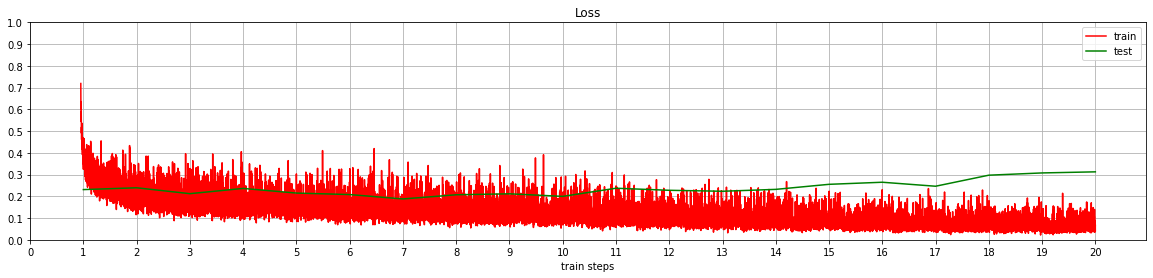

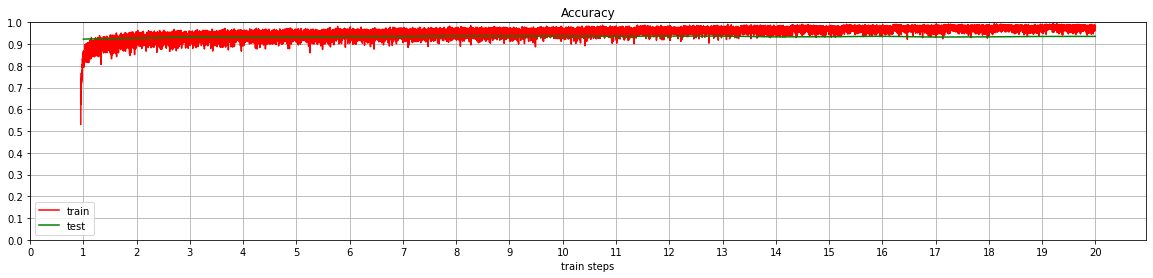

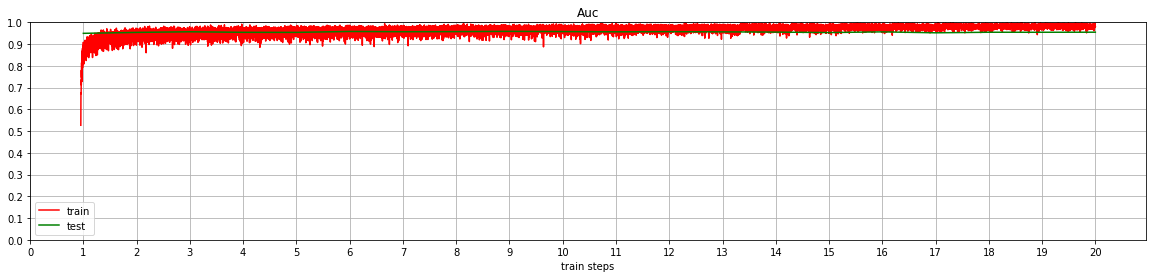

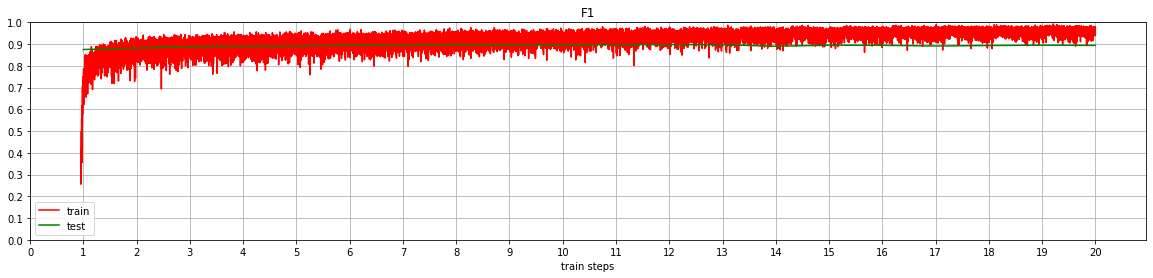

Time:  29113328.305040393
Epoch 20: ROC-AUC = 95.48%
Epoch 20: Precision = 0.899
Epoch 20: Recall = 0.89
Epoch 20: F1-score = 0.894
Final ROC-AUC = 95.48%
Final Precision = 0.899
Final Recall = 0.89
Final F1-score = 0.894
Omics features num: 30
Epoch 8
Max F1-score: 89.8518%
ROC-AUC: 95.7465%
Precision: 0.8956
Recall: 0.9023
Mean time for 1 epoch 3.43 minutes


In [26]:
train_on_reduced_omics(30)

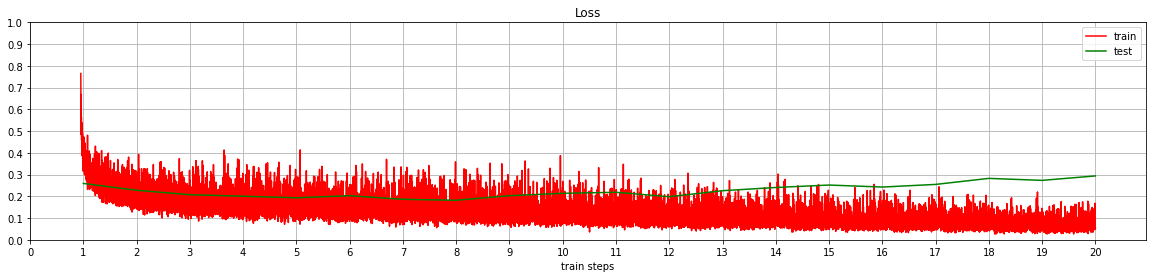

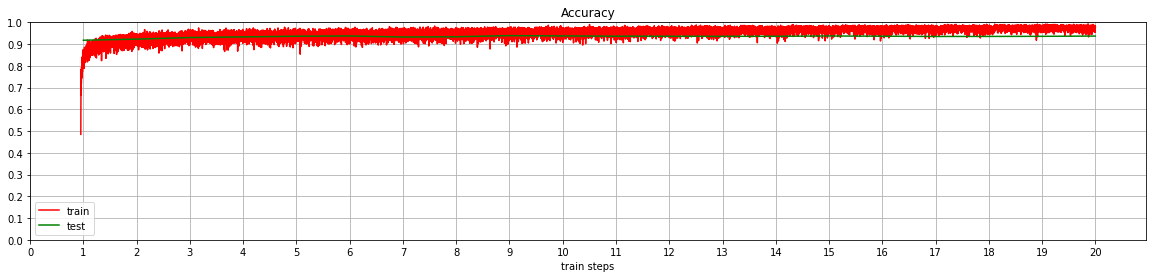

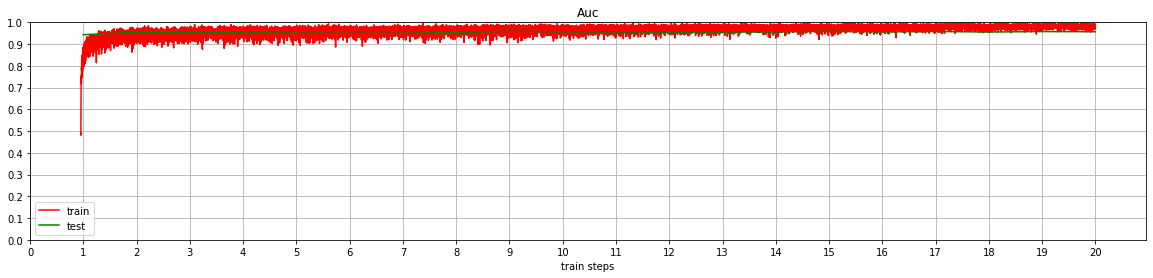

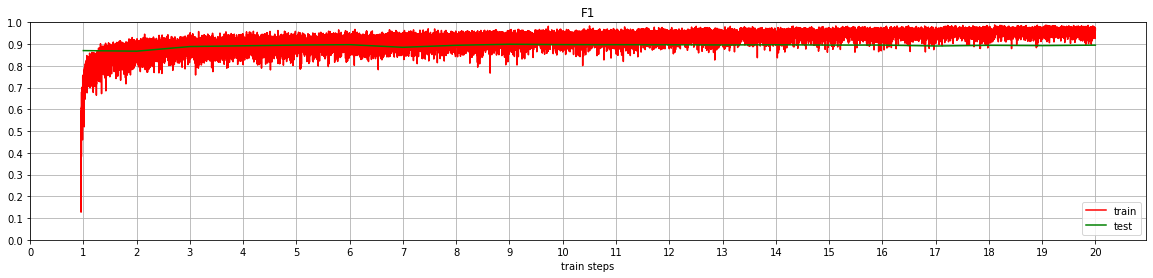

Time:  29113410.74904122
Epoch 20: ROC-AUC = 95.69%
Epoch 20: Precision = 0.915
Epoch 20: Recall = 0.877
Epoch 20: F1-score = 0.895
Final ROC-AUC = 95.69%
Final Precision = 0.915
Final Recall = 0.877
Final F1-score = 0.895
Omics features num: 50
Epoch 9
Max F1-score: 89.9284%
ROC-AUC: 95.8958%
Precision: 0.9126
Recall: 0.8872
Mean time for 1 epoch 3.33 minutes


In [27]:
train_on_reduced_omics(50)

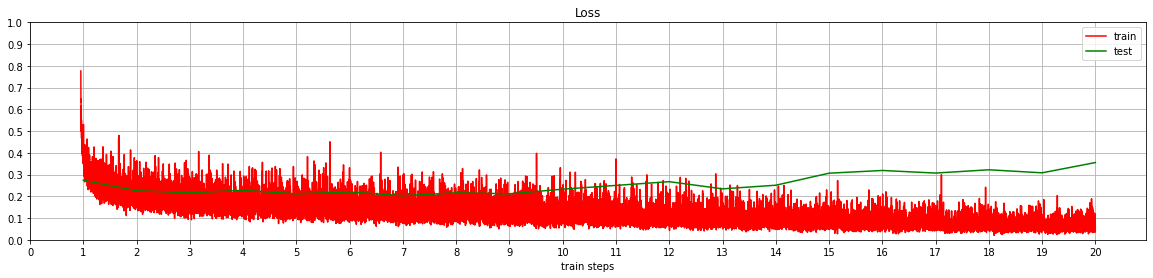

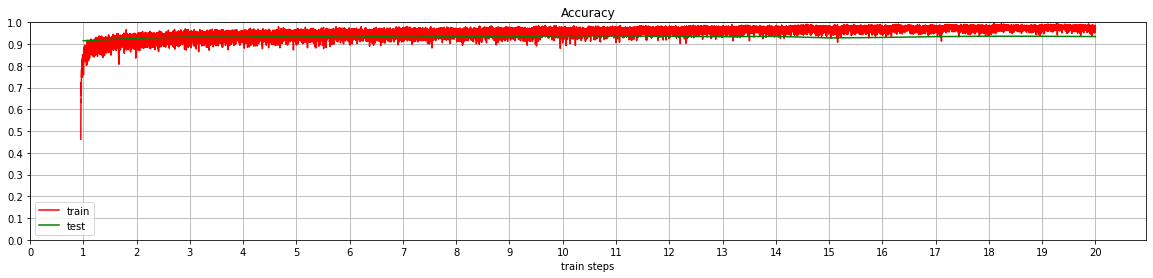

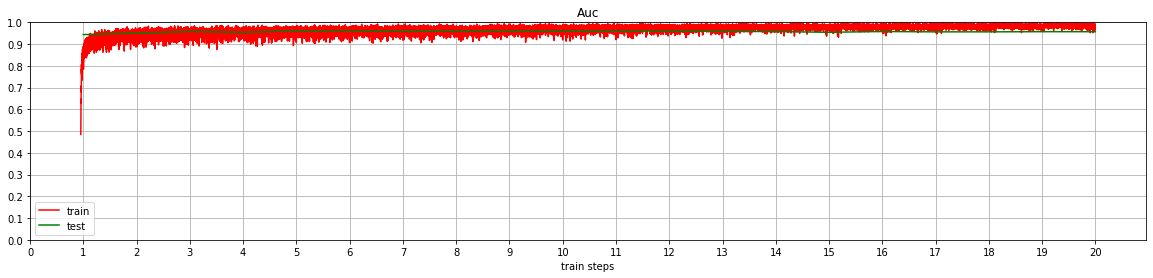

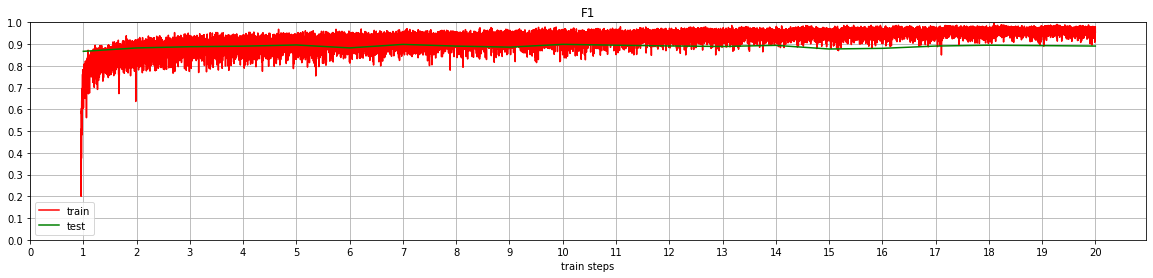

Time:  29113505.3940181
Epoch 20: ROC-AUC = 95.70%
Epoch 20: Precision = 0.915
Epoch 20: Recall = 0.869
Epoch 20: F1-score = 0.891
Final ROC-AUC = 95.7%
Final Precision = 0.915
Final Recall = 0.869
Final F1-score = 0.891
Omics features num: 100
Epoch 10
Max F1-score: 89.8889%
ROC-AUC: 95.9567%
Precision: 0.9111
Recall: 0.8878
Mean time for 1 epoch 3.93 minutes


In [28]:
train_on_reduced_omics(100)

## Postfiltered

### IG + IXG

In [19]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)

In [20]:
features = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells')
            if i.endswith('.pkl')]

features_top = features_range.iloc[4:len(features)+4].index.tolist()

top = []
for index in features_top:
    top.append(features[index-4])

features = top

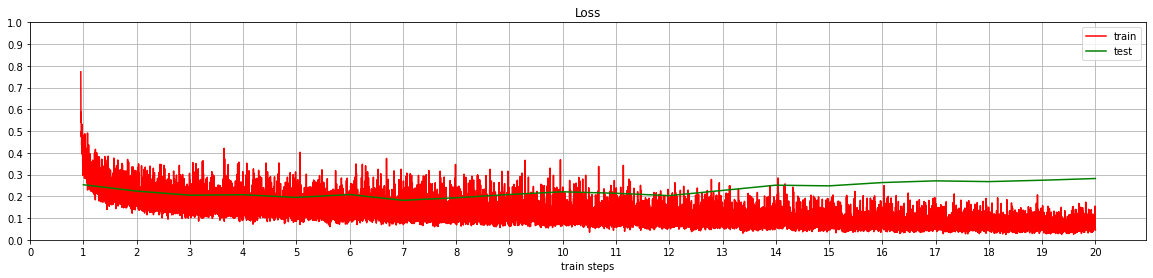

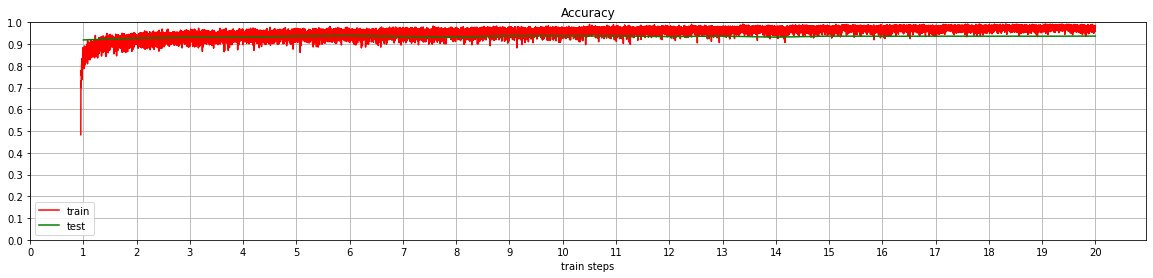

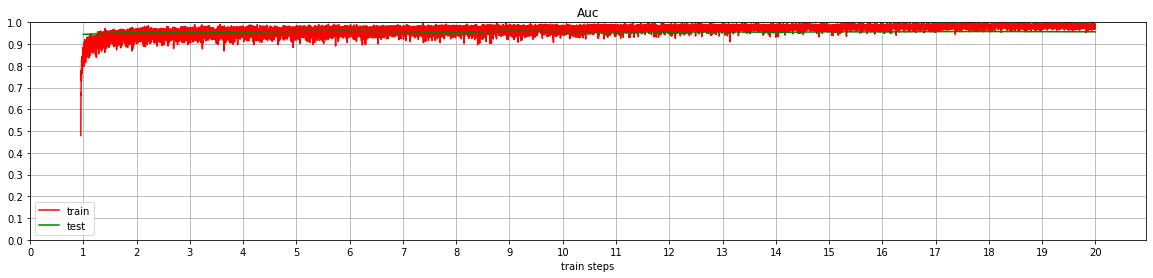

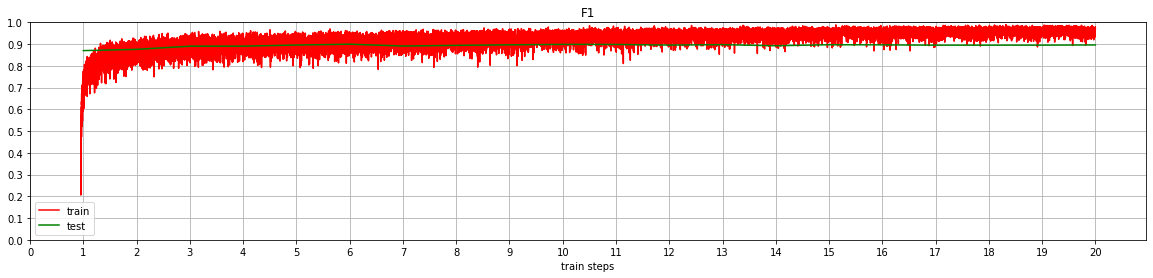

Time:  29119053.971933678
Epoch 20: ROC-AUC = 95.65%
Epoch 20: Precision = 0.907
Epoch 20: Recall = 0.887
Epoch 20: F1-score = 0.896
Final ROC-AUC = 95.65%
Final Precision = 0.907
Final Recall = 0.887
Final F1-score = 0.896
Omics features num: 50
Epoch 6
Max F1-score: 89.9604%
ROC-AUC: 95.9559%
Precision: 0.9080
Recall: 0.8921
Mean time for 1 epoch 1.43 minutes


In [23]:
train_on_reduced_omics(50, "postfiltered_IG_IXG")

### IG + IXG + GB

In [21]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG, 'GB' : mean_GB}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)

In [22]:
features = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells')
            if i.endswith('.pkl')]

features_top = features_range.iloc[4:len(features)+4].index.tolist()

top = []
for index in features_top:
    top.append(features[index-4])

features = top

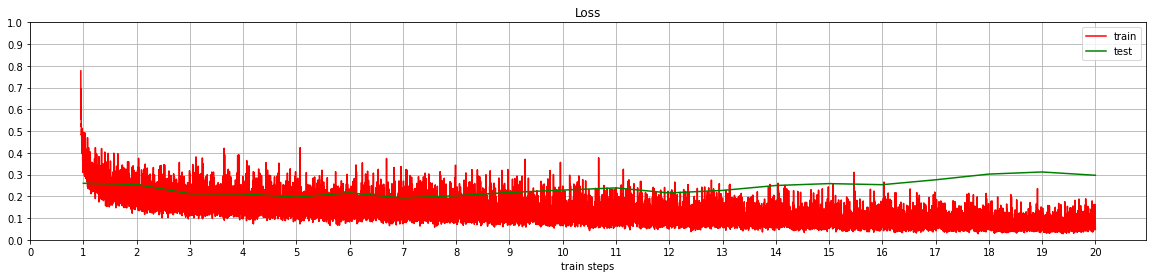

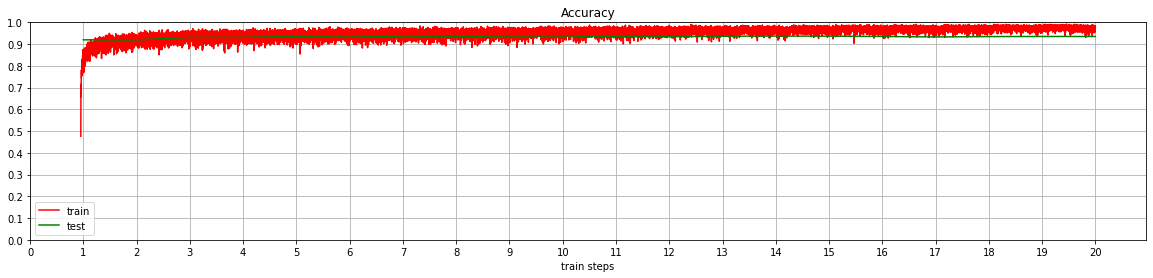

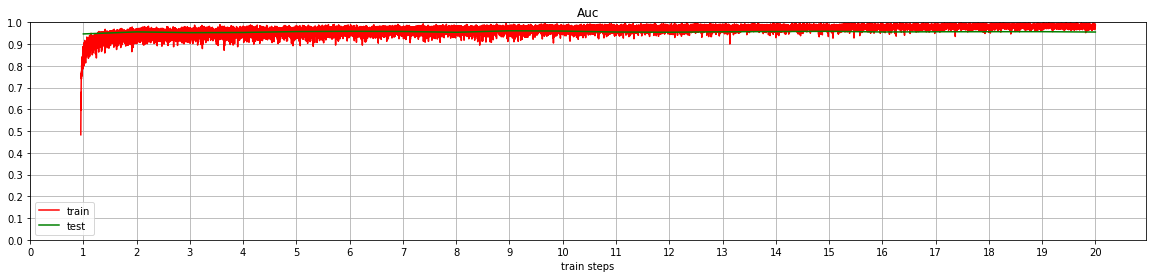

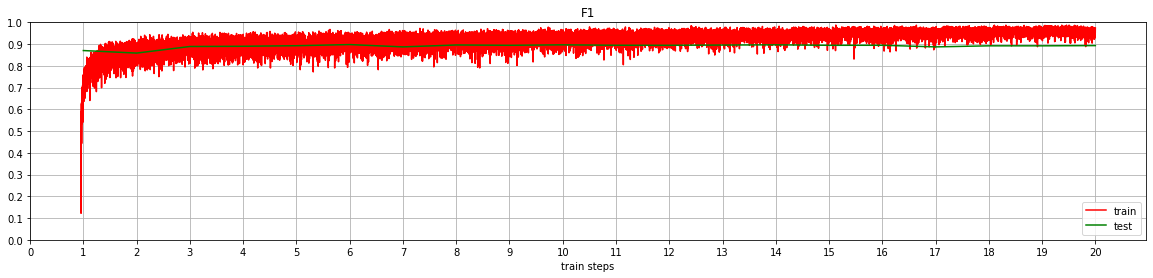

Time:  29119003.01364489
Epoch 20: ROC-AUC = 95.55%
Epoch 20: Precision = 0.905
Epoch 20: Recall = 0.883
Epoch 20: F1-score = 0.893
Final ROC-AUC = 95.55%
Final Precision = 0.905
Final Recall = 0.883
Final F1-score = 0.893
Omics features num: 50
Epoch 6
Max F1-score: 89.7880%
ROC-AUC: 95.8854%
Precision: 0.9049
Recall: 0.8918
Mean time for 1 epoch 1.38 minutes


In [16]:
train_on_reduced_omics(50, "postfiltered_IG_IXG_GB")

## Save best ranking

In [27]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)

In [28]:
features = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells')
            if i.endswith('.pkl')]

features_top = features_range.iloc[4:len(features)+4].index.tolist()

top = []
for index in features_top:
    top.append(features[index-4])

features = top

In [29]:
features[:20]

['Histone_H3K4me3',
 'TFs_and_others_BRCA1',
 'RNA_polymerase_RNA_polymerase_II',
 'TFs_and_others_ZMAT4',
 'Histone_H2A.Z',
 'TFs_and_others_KDM2A',
 'TFs_and_others_EPOP',
 'TFs_and_others_ISL1',
 'TFs_and_others_CHD6',
 'Histone_H4K20me1',
 'TFs_and_others_PAF1',
 'TFs_and_others_ZNF143',
 'TFs_and_others_KLF4',
 'TFs_and_others_PRDM1',
 'Histone_H3K27me3',
 'TFs_and_others_FOXP1',
 'TFs_and_others_GFP',
 'TFs_and_others_INTS10',
 'TFs_and_others_SMARCA4',
 'TFs_and_others_FGFR1']

In [30]:
torch.save(features, "./interpretation_results/zdna/best_omicses_ranking.pt")